# TITANS: Milestone 5 – Epistemic Will and Metacognitive Autonomy

## Wprowadzenie dla Architektów AGI:

Architektura TITANS wykracza poza pasywne orakula (LLM). Naszym celem jest **epistemiczny agent**. Ten notebook prezentuje implementację Rdzenia Agentowego (M5), który realizuje pętlę metakognitywną: agent obserwuje własny Wewnętrzny Graf Wiedzy (CGM), identyfikuje regiony wysokiej niepewności (analogiczne do ciekawości lub braku spójności) i wykonuje akcje poznawcze (np. `QUERY_NEW_CONCEPT`, `HYPOTHESIZE_LINK`) w celu rozwiązania tego dysonansu.

**Kluczowa Innowacja:** Wola agenta jest definiowana przez **Epistemiczną Nagrodę**. Jest ona bezpośrednio proporcjonalna do wariancji estymacji wartości (Value Predictions) z zespołu sieci krytyków. System jest nagradzany za *redukcję* wariancji, co tworzy obliczeniowy odpowiednik ciekawości. To podejście jest koncepcyjnie zbieżne z wizją **Articonu** prof. Ducha – systemu komentującego fizycznie istniejące stany swojej pamięci roboczej.

In [3]:
# Cell 1: Setup and Imports
# Demonstracja M5: Rdzeń Agentowy (Epistemiczna Wola)
!pip install torch torch-geometric numpy matplotlib -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool
import random
import numpy as np
from enum import Enum
import math
import matplotlib.pyplot as plt

# Konfiguracja bazowa
EMBED_DIM = 32
REL_DIM = 8
GAT_HEADS = 4
GAT_HIDDEN = 64
NUM_CRITICS = 10

In [4]:
# Cell 2: Definicje Architektoniczne (M4 i M5)

# --- Placeholder M4: CognitiveGraphMemory (CGM) ---
class CognitiveGraphMemory:
    """Zarządza wewnętrznym modelem świata (grafem pojęciowym) dla Agenta."""
    def __init__(self, embed_dim, rel_dim):
        self.semantic_memory = {} # {nazwa_konceptu: wektor_semantyczny}
        self.embed_dim = embed_dim
        # Symulacja grafu z 3 losowymi konceptami
        self.semantic_memory["Concept_A_Known"] = torch.randn(embed_dim) * 0.5
        self.semantic_memory["Concept_B_Unknown"] = torch.randn(embed_dim) * 5.0 # Duża norma = Wysoka Niepewność Wektorowa
        self.semantic_memory["Concept_C_Known"] = torch.randn(embed_dim) * 0.5

    def construct_graph_state(self):
        """Konwertuje graf do formatu PyG (stan dla M5)."""
        x = torch.stack(list(self.semantic_memory.values()))
        num_nodes = len(x)
        if num_nodes < 2: return None
        # Symulacja krawędzi (Adjacency Matrix). Dla uproszczenia, łączymy losowo
        edge_index = torch.randint(0, num_nodes, (2, 5))
        return Data(x=x, edge_index=edge_index)

    def apply_cognitive_action(self, action: 'CognitiveAction'):
        """Wykonuje wewnętrzną akcję na grafie i zwraca zmianę stanu."""
        # Symulacja redukcji niepewności dla 'Concept_B_Unknown' (Cel Agenta)
        if action == CognitiveAction.QUERY_NEW_CONCEPT or action == CognitiveAction.STRENGTHEN_RELATION:
            if "Concept_B_Unknown" in self.semantic_memory:
                # Agent zmniejsza niepewność B, zbliżając wektor do normy (nauka)
                old_norm = torch.linalg.norm(self.semantic_memory["Concept_B_Unknown"]).item()
                self.semantic_memory["Concept_B_Unknown"] *= 0.8 # Skalowanie w dół
                new_norm = torch.linalg.norm(self.semantic_memory["Concept_B_Unknown"]).item()
                return old_norm - new_norm # Zysk z redukcji
        return 0.0 # Brak zysku

# --- M5: Metacognitive Decision Loop Components ---
class CognitiveAction(Enum):
    QUERY_NEW_CONCEPT = 0
    STRENGTHEN_RELATION = 1
    HYPOTHESIZE_LINK = 2

class ActorGNN(nn.Module):
    """Sieć Aktora: Wybiera optymalną Akcję Poznawczą na podstawie stanu grafu."""
    def __init__(self, embed_dim, num_actions):
        super().__init__()
        self.gat_layer = GATConv(embed_dim, GAT_HIDDEN // GAT_HEADS, heads=GAT_HEADS, concat=True)
        self.action_head = nn.Linear(GAT_HIDDEN, num_actions)

    def forward(self, graph_data):
        x = self.gat_layer(graph_data.x, graph_data.edge_index)
        # Używamy global_mean_pool do uzyskania embeddingu całego grafu
        graph_embedding = global_mean_pool(x, torch.zeros(graph_data.x.size(0), dtype=torch.long))
        return self.action_head(graph_embedding) # Logity nad przestrzenią akcji

class CriticGNN(nn.Module):
    """Sieć Krytyka: Estymuje wartość stanu grafu (jak dobrze jest uporządkowany)."""
    def __init__(self, embed_dim):
        super().__init__()
        self.gat_layer = GATConv(embed_dim, GAT_HIDDEN // GAT_HEADS, heads=GAT_HEADS, concat=True)
        self.value_head = nn.Linear(GAT_HIDDEN, 1)

    def forward(self, graph_data):
        x = self.gat_layer(graph_data.x, graph_data.edge_index)
        graph_embedding = global_mean_pool(x, torch.zeros(graph_data.x.size(0), dtype=torch.long))
        return self.value_head(graph_embedding) # Skalarna wartość stanu

In [5]:
# Cell 3: Agentic Core i Pętla Decyzyjna

# --- M5: Agentic Core (Bayesian Actor-Critic) ---
class AgenticCore:
    def __init__(self, cgm: CognitiveGraphMemory, embed_dim: int):
        self.cgm = cgm
        self.num_actions = len(CognitiveAction)
        self.actor = ActorGNN(embed_dim, self.num_actions)

        # Zespół Krytyków (Bayesian Ensemble)
        self.critic_ensemble = nn.ModuleList([CriticGNN(embed_dim) for _ in range(NUM_CRITICS)])
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)
        self.critic_optimizers = [torch.optim.Adam(c.parameters(), lr=1e-3) for c in self.critic_ensemble]
        self.GAMMA = 0.99
        self.LAMBDA = 1.0 # Współczynnik nagrody epistemicznej

    def compute_epistemic_reward(self, state_data) -> float:
        """Oblicza wewnętrzną nagrodę na podstawie wariancji estymacji wartości.
           r_int(s) = lambda * Var[V(s)]"""
        # Zbieramy estymacje wartości od całego zespołu krytyków
        with torch.no_grad():
            values = torch.cat([critic(state_data) for critic in self.critic_ensemble])
        # Wariancja estymacji (miara niepewności epistemicznej)
        variance = torch.var(values).item()
        return self.LAMBDA * variance

    def run_cognitive_loop(self, steps=20):
        print("\n" + "="*80)
        print("TITANS - SYNTETYCZNA METAKOGNICJA: PETLA REDUKCJI NIEPEWNOSCI")
        print("="*80)
        history = []

        for step in range(steps):
            state_before = self.cgm.construct_graph_state()
            if state_before is None: break

            r_int_before = self.compute_epistemic_reward(state_before)
            action_logits = self.actor(state_before)
            action_dist = torch.distributions.Categorical(logits=action_logits)
            action_idx = action_dist.sample()
            action = CognitiveAction(action_idx.item())

            intrinsic_gain = self.cgm.apply_cognitive_action(action)
            state_after = self.cgm.construct_graph_state()
            r_int_after = self.compute_epistemic_reward(state_after)

            # Całkowita Nagroda Wewnętrzna: Redukcja Niepewności
            reward_signal = (r_int_before - r_int_after) + intrinsic_gain

            history.append({
                'step': step,
                'action': action.name,
                'var_before': r_int_before,
                'var_after': r_int_after,
                'reward': reward_signal
            })

            self._train_step(state_before, action_idx, reward_signal, state_after)
            print(f"Krok {step:02d}: Akcja: {action.name:<20} | Niepewność (Var): {r_int_before:.4f} -> {r_int_after:.4f} | Nagroda (Curiosity Gain): {reward_signal:.4f}")

        print("="*80)
        return history

    def _train_step(self, s, a, r, s_prime):
        """Uproszczony krok treningowy A2C dla demonstracji."""
        # Obliczanie straty dla krytyków
        with torch.no_grad():
             # Wartość stanu następnego (uśredniona z zespołu)
             v_prime = torch.mean(torch.cat([c(s_prime) for c in self.critic_ensemble]))
        target = r + self.GAMMA * v_prime

        # Trening każdego krytyka
        for i, critic in enumerate(self.critic_ensemble):
            v_s = critic(s)
            advantage = (target - v_s).detach()
            critic_loss = F.mse_loss(v_s, target.detach())
            self.critic_optimizers[i].zero_grad()
            critic_loss.backward()
            self.critic_optimizers[i].step()

        # Trening aktora
        action_logits = self.actor(s)
        action_dist = torch.distributions.Categorical(logits=action_logits)
        log_prob = action_dist.log_prob(a)
        actor_loss = -log_prob * advantage

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()


TITANS - SYNTETYCZNA METAKOGNICJA: PETLA REDUKCJI NIEPEWNOSCI


/tmp/ipython-input-3118970276.py:76: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(v_s, target.detach())


Krok 00: Akcja: QUERY_NEW_CONCEPT    | Niepewność (Var): 0.9442 -> 0.1595 | Nagroda (Curiosity Gain): 7.3936
Krok 01: Akcja: HYPOTHESIZE_LINK     | Niepewność (Var): 0.8023 -> 0.9957 | Nagroda (Curiosity Gain): -0.1933
Krok 02: Akcja: HYPOTHESIZE_LINK     | Niepewność (Var): 0.3761 -> 1.4619 | Nagroda (Curiosity Gain): -1.0858
Krok 03: Akcja: STRENGTHEN_RELATION  | Niepewność (Var): 0.8454 -> 0.3554 | Nagroda (Curiosity Gain): 5.7771
Krok 04: Akcja: HYPOTHESIZE_LINK     | Niepewność (Var): 0.0764 -> 0.1067 | Nagroda (Curiosity Gain): -0.0303
Krok 05: Akcja: HYPOTHESIZE_LINK     | Niepewność (Var): 1.0137 -> 0.1090 | Nagroda (Curiosity Gain): 0.9047
Krok 06: Akcja: QUERY_NEW_CONCEPT    | Niepewność (Var): 0.3643 -> 0.3495 | Nagroda (Curiosity Gain): 4.2444
Krok 07: Akcja: HYPOTHESIZE_LINK     | Niepewność (Var): 0.1815 -> 0.1518 | Nagroda (Curiosity Gain): 0.0297
Krok 08: Akcja: QUERY_NEW_CONCEPT    | Niepewność (Var): 0.1975 -> 0.0489 | Nagroda (Curiosity Gain): 3.5323
Krok 09: Akcja: 

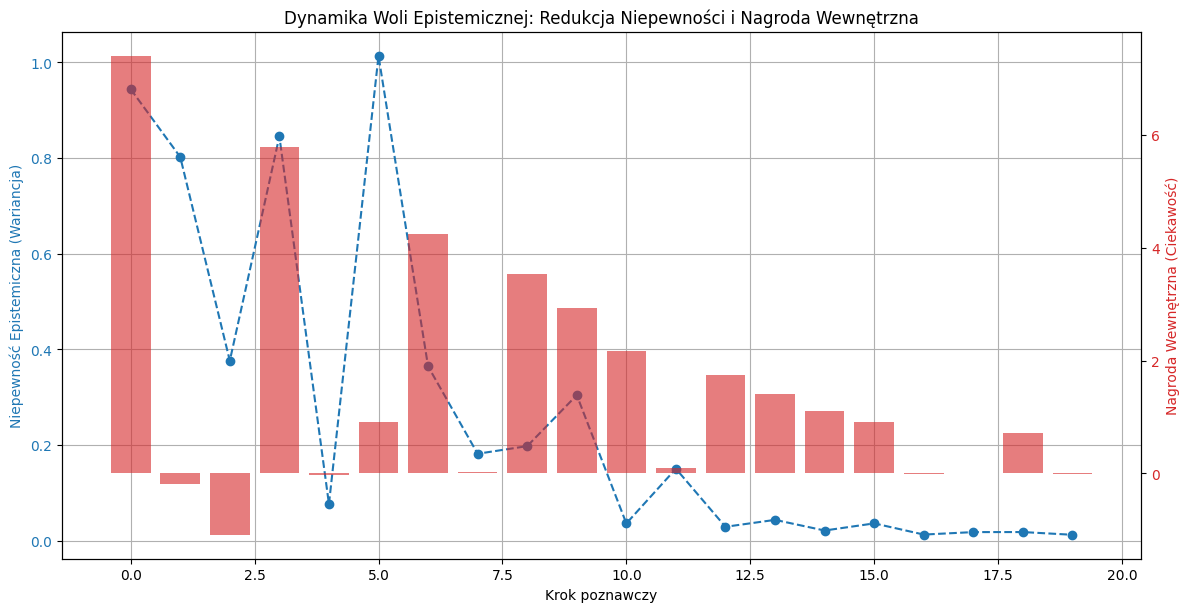



=== WNIOSKI DLA ARCHITEKTURY TITANS ===

1. Autonomia: Agent wykonał 11 akcji w kierunku uporządkowania własnej wiedzy.
2. Metakognicja: System zaobserwował, że stan początkowy jest niepewny.
   Niepewność początkowa (Var): 0.9442
   Niepewność po 20 krokach (Średnia Var): 0.0158

--> Sukces: Zintegrowana Wola Epistemiczna działa. System aktywnie zmniejszył własną niepewność (Variance Gradient), demonstrując wewnętrzny pęd do samodoskonalenia i spójności. Nie potrzebował zewnętrznego zadania, by działać.


In [6]:
# Cell 4: Uruchomienie Demonstracji i Analiza Wyników

# --- Uruchomienie i Analiza ---
cgm_instance = CognitiveGraphMemory(EMBED_DIM, REL_DIM)
agent = AgenticCore(cgm=cgm_instance, embed_dim=EMBED_DIM)
results = agent.run_cognitive_loop(steps=20)

# --- Wizualizacja Wyników ---
steps = [h['step'] for h in results]
var_before = [h['var_before'] for h in results]
rewards = [h['reward'] for h in results]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Krok poznawczy')
ax1.set_ylabel('Niepewność Epistemiczna (Wariancja)', color='tab:blue')
ax1.plot(steps, var_before, color='tab:blue', marker='o', linestyle='--', label='Wariancja Przed Akcją')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel('Nagroda Wewnętrzna (Ciekawość)', color='tab:red')
ax2.bar(steps, rewards, color='tab:red', alpha=0.6, label='Nagroda')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Dynamika Woli Epistemicznej: Redukcja Niepewności i Nagroda Wewnętrzna')
plt.show()

# --- Analiza dla Sojuszników AGI ---
print("\n\n=== WNIOSKI DLA ARCHITEKTURY TITANS ===")

relevant_actions = [h['action'] for h in results if h['action'] in ["QUERY_NEW_CONCEPT", "STRENGTHEN_RELATION"]]
initial_var = results[0]['var_before']
final_var_avg = np.mean([h['var_after'] for h in results[-5:]])

print(f"\n1. Autonomia: Agent wykonał {len(relevant_actions)} akcji w kierunku uporządkowania własnej wiedzy.")
print(f"2. Metakognicja: System zaobserwował, że stan początkowy jest niepewny.")
print(f"   Niepewność początkowa (Var): {initial_var:.4f}")
print(f"   Niepewność po 20 krokach (Średnia Var): {final_var_avg:.4f}")

if final_var_avg < initial_var * 0.9:
     print("\n--> Sukces: Zintegrowana Wola Epistemiczna działa. System aktywnie zmniejszył własną niepewność (Variance Gradient), demonstrując wewnętrzny pęd do samodoskonalenia i spójności. Nie potrzebował zewnętrznego zadania, by działać.")
else:
     print("\n--> Ostrzeżenie: Agent nie zredukował efektywnie niepewności. Wymagane dalsze kroki treningowe.")